In [1]:
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import h5netcdf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import NaturalEarthFeature
from matplotlib import colors
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

# Investigation into individual countries time series
The continuity of a time series is important because it ensures that the data accurately represents the underlying phenomenon/process being measured or observed (in our case, the grid/country/global population or gdp).
A lack of continuity can introduce biases, distortions, or inaccuracies in the analysis and interpretation of the data.

In the following, we showcase several cases where the population/gdp data used in ISIMIP2 lacks in continuity.
We begin our assessment with country level time series.
Once we understand the issue, we can design a correction algorithm to adress it.

## Load the raw data and define the objects which will support the analysis:

In [2]:
# Load the gdp data from 1861 till 2100
#hist_data = xr.open_dataset("../data/population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4", engine='h5netcdf', decode_times=False).pop[:,:,:]
gdp_hist =  xr.open_dataset('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP2b/InputData/gdp/histsoc/gdp_histsoc_0p5deg_annual_1861-2005.nc4')
gdp_fut = xr.open_dataset('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP2b/InputData/gdp/rcp26soc/gdp_rcp26soc_0p5deg_annual_2006-2099.nc4')
hist_data = xr.concat([gdp_hist,gdp_fut],dim='time')['gdp']

In [3]:
# Define the regions over which future masking will be applied
# In our case we are interested in country level aggregation
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries.plot(add_label=False)

<GeoAxesSubplot:>

In [4]:
# Generate a mask object for each country based on the grid of our input data
# This will result in an object that for a given country will have all corresponding gridcells filled with the country index value
# For example for US all corresponding gridcells will be filled with "4"
# All gridcells which are not part of any country will be filled with NaN
mask = countries.mask(hist_data[0,:,:]).fillna(177) # we fillna values with a custom key "177" because some of these points, not identified as countries due to limits of regionmask package, actually contain some population (e.g., an insular country or not attributed coastline gridcells) and using this key we can still have access to these points

# Obtain a list of all countries names and index:
countries_names = countries.names
countries_index = countries.numbers

# Create a fictive country which would contain all the 177 masked gridcells
countries_names.append("Not a regionmask country")
countries_index.append(177)


## Compute individual countries time series:

In [5]:
# Initialize a zero array with countries and time dimensions
country_pop_timeseries = xr.DataArray(np.zeros((178, 240)), dims=('country', 'time'), 
                                      coords={'country': countries_index, 'time': range(1861, 2101)})

# Loop over years:
for year in range(1861, 2100):
    # Loop over each countries:
    for country in range(len(countries_index)):
        # Calculate country total population for given year
        country_pop_timeseries[country, year-1861] = np.nansum(hist_data[year-1861].where(mask == country))
    
    if year%20 == 0:
        print("Year completed: " + str(year))

Year completed: 1880
Year completed: 1900
Year completed: 1920
Year completed: 1940
Year completed: 1960
Year completed: 1980
Year completed: 2000
Year completed: 2020
Year completed: 2040
Year completed: 2060
Year completed: 2080


In [6]:
# Assuming time series starts from 1861 and ends in 2100
years = pd.date_range(start='1861', periods=240, freq='Y').year

# Iterate over each country and its population time series
for i, country in enumerate(countries_names):
    pop_timeseries_original = country_pop_timeseries[i]  # Original data, no changes
    
    # Creating a DataFrame for easy manipulation
    df = pd.DataFrame({'Year': years, 'Population_original': pop_timeseries_original})
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], df['Population_original'], 'ro', markersize=3)
    plt.axvline(x=2005, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.axvline(x=2010, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.title(country)
    plt.xlabel('Year')
    plt.ylabel('GDP')
    
    # Save to pdf
    pdf_path = f"../results/copy_results/{country}_original_gdp_time_series_1861_2100.pdf"
    plt.savefig(pdf_path, format='pdf')
    
    plt.close()

## Interpretation of the time series discontinuities:
By looking into each country time series, we can identify the following situation:
1) Some of the time series are almost perfectly continuous (e.g. Rwanda, Uganda, Ethiopia)
2) There is a big jump or drop in some countries' population time series between 2005 and 2011. Instead of bias adjusting the future or historic time series, it seems that the dataset was merged by performing a linear interpolation between 2005-2011. 
    While this seems to work in some cases, there are many instances where this causes unrealistic behavior. Such examples include: sudden drop, followed by sudden increase (e.g. S. Sudan), a big jump or drop between the affected time period (e.g. Djibouti, Somaliland), or stagnation followed by change again (e.g. for Not a regionmask fictive country).

## Solution: fix countries time series for GDP
Since for some countries, the original dataset seems perfectly fine, the correction algorithm is applied only for countries with visible anomalies.
The list of countries for which correction is needed is constructed by visually inspecting the original time series. 

In [7]:
# Specify the countries for which the correction algorithm will be applied:
list_of_countries_to_correct = ['Fiji',  'W. Sahara',  'Bahamas',  'Falkland Is.',  'Greenland',  'Lesotho',  'Belize',  'Jamaica',  'Botswana',  'Central African Rep.',  'Congo',  'Gabon',  'Lebanon',  'Palestine',  'Tunisia',  'Vanuatu',  'Bhutan', 'Kyrgyzstan', 'Turkmenistan',  'Armenia',  'Latvia',  'Estonia', 'Albania',  'Croatia',  'Ireland',  'New Caledonia',  'Solomon Is.',  'Sri Lanka', 'Taiwan', 'Italy',  'Iceland',  'Azerbaijan',  'Brunei',  'Slovenia',  'Czechia',  'Paraguay',  'N. Cyprus',  'Cyprus',  'Morocco', 'Djibouti', 'Somaliland', 'North Macedonia', 'Montenegro', 'Kosovo', 'Trinidad and Tobago', 'S. Sudan', 'Not a regionmask country']
# create a dictionary mapping country names to their indices
country_to_index = {name: index for index, name in enumerate(countries_names)}

# find the indices of the countries to be corrected
indices_to_correct = [country_to_index[country] for country in list_of_countries_to_correct if country in country_to_index]

# Store the corrected national population time series
corrected_country_pop_timeseries = country_pop_timeseries.copy(deep=True)

In [8]:
# Assuming time series starts from 1861 and ends in 2100
years = pd.date_range(start='1861', periods=240, freq='Y').year

# Determine index of years of interest
index_2003 = list(years).index(2003)
index_2005 = list(years).index(2005)
index_2006 = list(years).index(2006)
index_2010 = list(years).index(2010)
index_2011 = list(years).index(2011)
index_2015 = list(years).index(2015)

# Iterate over each country and its population time series
for i, country in enumerate(countries_names):
    pop_timeseries_original = country_pop_timeseries[i]  # Original data, no changes
    pop_timeseries_corrected = country_pop_timeseries[i].copy(deep=True)  # Corrected data, we will change this
        
    # Make the slope transition smoother between 2006-2011 if country in the list to be corrected
    if country in list_of_countries_to_correct:
        # Calculate the difference between years 2005 and 2006
        diff_2005_2006 = pop_timeseries_corrected[index_2006] - pop_timeseries_corrected[index_2005]

        # Calculate the average annual change in population over 2003-2005
        avg_annual_change_between_2005_and_2003 = (pop_timeseries_corrected[index_2005] - pop_timeseries_corrected[index_2003]) / 3.0

        # Calculate the average annual change in population over 2011-2015
        avg_annual_change_between_2015_and_2011 = (pop_timeseries_corrected[index_2015] - pop_timeseries_corrected[index_2011]) / 5.0

        # Create an array with increments transitioning from avg_annual_change_between_2005_and_2003 to avg_annual_change_between_2015_and_2011
        # This allows for a smooth transition, with the slopes gradually increasing/decreasing to properly transition between the period 2006-2011
        increment_values = np.linspace(avg_annual_change_between_2005_and_2003, avg_annual_change_between_2015_and_2011, index_2011 - index_2006)
        for j in range(index_2006, index_2011):
            pop_timeseries_corrected[j] = pop_timeseries_corrected[j-1] + increment_values[j-index_2006]

    # Calculate the difference between years 2010 and 2011
    diff_2010_2011 = pop_timeseries_corrected[index_2011] - pop_timeseries_corrected[index_2010]

    # Adjust the population in 2011 and afterward if country in the list to be corrected
    if country in list_of_countries_to_correct:
        pop_timeseries_corrected[index_2011:] = pop_timeseries_corrected[index_2011:] + avg_annual_change_between_2015_and_2011 - diff_2010_2011
        
    
    corrected_country_pop_timeseries[i] = pop_timeseries_corrected
    
    df = pd.DataFrame({'Year': years, 'Population_original': pop_timeseries_original, 'Population_corrected': pop_timeseries_corrected})
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], df['Population_original'], 'ro', markersize=3, label='Original GDP')
    plt.plot(df['Year'], df['Population_corrected'], 'k-', label='Corrected GDP')
    plt.axvline(x=2005, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.axvline(x=2010, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.title(country)
    # Add text box with "Corrected" or not label
    if country in list_of_countries_to_correct:
        plt.text(0.1, 0.6, 'Corrected', transform=plt.gca().transAxes, fontsize=14,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        plt.text(0.1, 0.6, 'No correction needed', transform=plt.gca().transAxes, fontsize=14,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Add a legend
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('GDP')
    
    # Save to pdf
    pdf_path = f"../results/copy_results/{country}_corrected_gdp_time_series_1861_2100.pdf"
    plt.savefig(pdf_path, format='pdf')
    
    plt.close()


# Downscale the corrected countries' GDP time series
After correcting the time series at country level, we should update the individual gridcells values accordingly.
To do so, we apply the same gridcells weights as in the original population dataset to perform the spatial downscaling of the new national time series.

The correction will be done only for the corrected countries for computational efficiency, and only for the affected period, which is 2006-2100.

In [9]:
hist_data_with_corrected_national_time_series = hist_data.copy(deep=True)

In [11]:
downscaling_coefficients = hist_data_with_corrected_national_time_series[0, :, :].copy(deep=True)*0.0
corrected_data_for_given_year = hist_data_with_corrected_national_time_series[:, :, :].copy(deep=True)*0.0 
mask_with_total_corrected_countries_population = hist_data_with_corrected_national_time_series[0, :, :].copy(deep=True)*0.0 
array_ones = hist_data_with_corrected_national_time_series[0, :, :].copy(deep=True)*0.0 +1.0 

# Iterate over each year and country
for year in range(1861, 2100):
    downscaling_coefficients *= 0.0
    mask_with_total_corrected_countries_population *=0.0
    
    for country in range(len(countries_index)):
        # Calculate country total population for given year
        corrected_country_total_population_given_year = np.nansum(corrected_country_pop_timeseries[country, year-1861].where(mask == country))
        
        original_country_total_population_given_year = np.nansum(country_pop_timeseries[country, year-1861].where(mask == country))
        downscaling_coefficients = downscaling_coefficients + (hist_data[year-1861].where(mask == country)/original_country_total_population_given_year).fillna(0) # fillna(0) used to avoid summation with NaN values which would occur because using masking for second term of the summation

        # Save total corrected country population value in each gridcell corresponding to this country
        mask_with_total_corrected_countries_population = mask_with_total_corrected_countries_population + (array_ones.where(mask == country)*corrected_country_total_population_given_year).fillna(0)
        
        if (country != 23 and country !=159): # if country different from Fr. S. Antarctic Lands and Antarctica where population is 0
            # Check if total countries' population was saved correctly in each gridcell corresponding to that country
            # We do this by: [[sum over all grid points in mask_with_total_countries_population corresponding to given country]/[number of grid points part of given country]]/[country total population for given year obtained from scenario dataset] - 1 
            # If the procedure was performed correctly, this operation should give 0 within certain numerical error (here acceptable limit 10e-6)  
            if np.abs(np.nansum(mask_with_total_corrected_countries_population.where(mask==country).values)/np.nansum(np.isnan(mask_with_total_corrected_countries_population.where(mask==country).values) == False)/corrected_country_total_population_given_year - 1) > 10e-6:
                print("ERROR: it seems that country total population was not saved correctly in each gridcell.")
                print("This will cause incorect downscaling.")
                print("Please check the code for potential issues.")
                print("The error message concerns: " + str(countries_names[country]))
                print("For assistance, if required, please contact sabin.taranu@vub.be")
        
    # Here we assemble the gridded corrected population data for given year as the sum of downscaled total countries' population for given year (correction achieved for 177 countries + 1 fictive country corresponding to gridcells outside the regionmask countries)
    corrected_data_for_given_year[year-1861] = corrected_data_for_given_year[year-1861] + mask_with_total_corrected_countries_population*downscaling_coefficients
    # Return 0 population values into NaNs:
    corrected_data_for_given_year[year-1861] = corrected_data_for_given_year[year-1861].where(corrected_data_for_given_year[year-1861] != 0)
    
    if year%20 == 0:
        print("Year completed: " + str(year))

Year completed: 1880
Year completed: 1900
Year completed: 1920
Year completed: 1940
Year completed: 1960
Year completed: 1980
Year completed: 2000
Year completed: 2020
Year completed: 2040
Year completed: 2060
Year completed: 2080


In [12]:
# Save the new data
corrected_data_for_given_year.to_netcdf(path = "../corrected/gdp_with_corrected_countries_time_series_1861_2099.nc")

# Check that our correction was successful, and that the new gridded population dataset when aggregated at country level is fully matching the corrected_country_pop_timeseries

In [14]:
# Initialize a zero array with countries and time dimensions
country_pop_timeseries_aggregated_from_the_country_time_series_corrected_dataset = xr.DataArray(np.zeros((178, 240)), dims=('country', 'time'), 
                                      coords={'country': countries_index, 'time': range(1861, 2101)})

# Loop over years:
for year in range(1861, 2100):
    # Loop over each countries:
    for country in range(len(countries_index)):
        # Calculate country total population for given year
        country_pop_timeseries_aggregated_from_the_country_time_series_corrected_dataset[country, year-1861] = np.nansum(corrected_data_for_given_year[year-1861].where(mask == country))
        
    if year%20==0:
        print("Year completed: " + str(year))

Year completed: 1880
Year completed: 1900
Year completed: 1920
Year completed: 1940
Year completed: 1960
Year completed: 1980
Year completed: 2000
Year completed: 2020
Year completed: 2040
Year completed: 2060
Year completed: 2080


In [ ]:
if np.abs(np.nansum(country_pop_timeseries_aggregated_from_the_country_time_series_corrected_dataset-corrected_country_pop_timeseries)) > 10e-8*(np.max(corrected_country_pop_timeseries.sum('country'))):
    print("It seems an error was produced during the creation of the gridded dataset with corrected countries time series, as the difference between corrected countries time series and re-aggregated time series is larger than expected numerical error limit.")
    print("np.nansum(country_pop_timeseries_aggregated_from_the_country_time_series_corrected_dataset-corrected_country_pop_timeseries) = " + str(np.nansum(country_pop_timeseries_aggregated_from_the_country_time_series_corrected_dataset-corrected_country_pop_timeseries)))
    print("Please check the code for possible issue, or request assistance from sabin.taranu@vub.be if needed.")
else:
    print("The creation of the new gridded dataset with corrected countries time series was succesful!")

# Check global population before and after correction:
The results show that:
1) No correction was done till 2005.
2) The total contribution of the correction was an increase in the total global population by about 4-5 millions. This is insignificant change, which do not change drastically the nature of the scenario, at the same time ensuring high quality of individual countries time series
3) The offset is larger for the period 2005-2010 because this where linear interpolation was used in the original dataset, and where smoothing was used by us for some countries time series. 

In [ ]:
global_pop_original = country_pop_timeseries.sum('country')
global_pop_after_correcting_national_time_series = corrected_country_pop_timeseries.sum('country')

# Assuming that your time array looks something like this:
time = range(1861, 2101)

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the original global population with red circles
plt.plot(time, global_pop_original-global_pop_after_correcting_national_time_series, 'k-', label='Difference between original global population and one after correcting countries time series')


# Add legend
plt.legend()

# Add titles and labels
plt.title('Global Population from 1861 to 2100')
plt.xlabel('Year')
plt.ylabel('Global Population')

# Show the plot
plt.show()

# Spatial consistency of the dataset:
Since we are now sure that national time series are correct for each country, we also need to check how this national population is distributed across gridcells.
For example, Inne Valderkelen identified that there is a spatial inconsistency at the transition year 2005-2006, between the historic and ssp2 dataset.
The spatial inconsistency consist in the fact, that some gridcell time series experience a sudden drop or jump at the transition year (e.g. from 0 to 100000 people in one year).
This is an unrealistic behavior, making it impossible to use for analysis on gridcell level, and putting under question model results which were generated using this data.

While a solution was already proposed for this specific issue, it is worth looking if there are no similar issues for the remaining of years.
Also, to be more precise in our assessment of the spatial consistency, we will analyze this property at country level instead of global.

To do this, we need an objective metric to estimate the spatial consistency between each consecutive years.
For this scope, we propose the following metric:

metric_spatial_consistency_for_given_country_and_transition_year(N-1) =  Sum_over_all_grids[absolute_value(gridded_country_pop_year(N) - gridded_country_pop_year(N-1))]/[absolute_value(aggregated_country_pop_year(N) - aggregated_country_pop_year(N-1))] 

Normally, we can expect the following behavior from this metric:
1) If the weights of each gridcell for a given country, remain the same at the transition between the year N and N-1, then this metric will return 1. 
2) If the weights are changing, it means, that at the transition between year N and N-1, some grids gain population weight relatively to others in the same country. In this case the metric will return a value larger than 1. 

It should be mentioned that in theory, it is ok to have this metric > 1. Actually in reality, most of the time this will be the case, as human settlements in a given country can grow at different rates, which gradually is changing the grids weights with some places cumulating population faster or slower.

At the same time, if we observe an anomaly in this metric, with a sudden change significantly exceeding the normal statistics, it is likely due to a problem with the data.

In [ ]:
# Initialize a zero array with countries and time dimensions
metric_spatial_consistency_for_given_country_and_transition_year = xr.DataArray(np.zeros((178, 239)), dims=('country', 'time'), 
                                                                  coords={'country': countries_index, 'time': range(1861, 2100)})

# Loop over years:
for year in range(1861, 2100):
    # Loop over each countries:
    for country in range(len(countries_index)):
        # Calculate country total population for given year
        metric_spatial_consistency_for_given_country_and_transition_year[country, year-1861] = np.nansum(np.abs(corrected_data_for_given_year[year-1861+1].where(mask==country) - corrected_data_for_given_year[year-1861].where(mask==country)))/(np.abs(np.nansum(corrected_data_for_given_year[year-1861+1].where(mask==country)) - np.nansum(corrected_data_for_given_year[year-1861].where(mask==country))))

    if year%20==0:
        print("Year completed: " + str(year))

In [ ]:
# Assuming time series starts from 1861 and ends in 2100
years = pd.date_range(start='1861', periods=239, freq='Y').year

# Iterate over each country and its population time series
for i, country in enumerate(countries_names):
    country_spatial_consistency = metric_spatial_consistency_for_given_country_and_transition_year[i] 
    
    # Creating a DataFrame for easy manipulation
    df = pd.DataFrame({'Year': years, 'Country_spatial_consistency': country_spatial_consistency})
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Year'], df['Country_spatial_consistency'], 'k-', markersize=3)
    plt.axvline(x=2005, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.axvline(x=2010, color='green', linestyle='--')  # This line adds a vertical line at the year 2005
    plt.title(country)
    plt.xlabel('Year')
    plt.ylabel('Spatial Consistency Metric')
    
    # Save to pdf
    # pdf_path = f"../results/country_level_spatial_consistency/{country}_spatial_consistency_metric_1861_2100.pdf"
    pdf_path = f"../results/copy_results/{country}_spatial_consistency_metric_1861_2100.pdf"

    plt.savefig(pdf_path, format='pdf')
    
    plt.close()

# Understand normal vs spatial inconsistent behavior
As we mentioned, it is normal that sometimes the metric we compute exceeds 1.0.
This can correspond to a situation where population in one grid is changing faster than the others for the same country.

At the same time, we know that the years 2005-2010 are anomalous for the dataset, as spacial inconsistency is introduced through merging the historic and ssp data. Therefore, we can try to use this period to understand what an abnormal value for our metric is.

By collecting the statistics over the period 1861-2004 and 2005-2010 for all countries for our spatial inconsistency metric, we can build density functions. By comparing the two density functions, we can then understand what is the likely threshold over which, maybe, there is a spatial inconsistency situation.

In [ ]:
from scipy.stats import gaussian_kde

# assuming the xarray DataArray is already loaded as metric_spatial_consistency_for_given_country_and_transition_year

# Subset the data for the two periods
period1_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(1861,2004))
period2_data = metric_spatial_consistency_for_given_country_and_transition_year.sel(time=slice(2005,2010))

# Reshape data to 1D array for the KDE function
period1_data_1d = period1_data.values.flatten()
period2_data_1d = period2_data.values.flatten()

# Remove NaN and Inf values
period1_data_1d = period1_data_1d[~np.isnan(period1_data_1d) & ~np.isinf(period1_data_1d)]
period2_data_1d = period2_data_1d[~np.isnan(period2_data_1d) & ~np.isinf(period2_data_1d)]

# Replace values larger than 100 with 100
period1_data_1d = np.where(period1_data_1d > 100, 100, period1_data_1d)
period2_data_1d = np.where(period2_data_1d > 100, 100, period2_data_1d)

# Generate kernel density estimates for the two periods
kde1 = gaussian_kde(period1_data_1d)
kde2 = gaussian_kde(period2_data_1d)

# Define a range for the x-axis (you might want to adjust this based on your data)
x_range = np.linspace(min(min(period1_data_1d), min(period2_data_1d)), max(max(period1_data_1d), max(period2_data_1d)), 500)

# Evaluate the KDE functions on the x_range
kde1_eval = kde1.evaluate(x_range)
kde2_eval = kde2.evaluate(x_range)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde1_eval, label='1861-2004', color='blue')
plt.plot(x_range, kde2_eval, label='2005-2010', color='red')
plt.title('Probability Density Functions')
plt.xlabel('Metric')
plt.ylabel('Density')
plt.xlim([0,20])
plt.legend()
plt.show()

# What is the threshold?
A good estimate can be the moment when kde2_eval > kde1_eval

In [ ]:
threshold_spatial_inconsistency = x_range[kde2_eval > kde1_eval][0]
print(threshold_spatial_inconsistency)

# Solve the spatial inconsistency issue for 2005-2100
Here we use the same method as in the previous correction, with the exception that now we also created the fictive country "Not a regionmask country" (index 177), which helps achieve spatial consistency also for insular countries and coastline gridcells. 

In [ ]:
# Extract the year 2005 data from the reference population_histsoc_0p5deg_annual_1861-2005.nc4
# We want to achieve spatial consistency with this dataset for all future years in the scenarios data
ref_pop_2005 = xr.open_dataset("../corrected/population_with_corrected_countries_time_series_1861_2100.nc", engine='h5netcdf', decode_times=False).pop[144,:,:]

# Load the scenario population dataset we want to correct:
pop_future = xr.open_dataset("../corrected/population_with_corrected_countries_time_series_1861_2100.nc", engine='h5netcdf', decode_times=False).pop[145:,:,:]

# Generate a mask object for each country based on the grid of our input data
# This will result in an object that for a given country will have all corresponding gridcells filled with the country index value
# For example for US all corresponding gridcells will be filled with "4"
# All gridcells which are not part of any country will be filled with NaN
mask = countries.mask(ref_pop_2005).fillna(177) # we fillna values with a custom key "177" because some of these points not identified as countries due to limits of regionmask, actually contain some population (e.g., an insular country or not atributed coastline gridcell) and using this key we can still have access to these points

# Obtain a list of all countries names and index:
countries_names = countries.names
countries_index = countries.numbers

# Create a fictive country which would contain all the 999 masked gridcells
countries_names.append("Not a regionmask country")
countries_index.append(177)

# Get number of years in the future dataset to loop over
years = pop_future.shape[0]

# Destination to save file:
destination = "../corrected/"

# Name of corrected dataset:
file_name = "corrected_population_ssp2soc_0p5deg_annual_2006-2100.nc"
print("done")

In [ ]:
# Prepare the correction indices
# The meaning of this dataset for a given country is: what fraction of the given country total population is located in a given gridcell
# For example if we mask for US (index 4), and we find that one gridcell in correction_indices for US contains the value 0.05,
# it means that this gridcell contains 5% of total US population
# If we want to obtain spatially consistent data at the transition between 2005 and 2006, it means that for each country, these fraction coefficients should stay the same during the transition and for future years
correction_indices = ref_pop_2005.copy(deep = True)*0.0 # initialize each gridcell with dummy data (zeros)

# Loop over each country
for country in range(len(countries_index)):
    # Calculate country total population
    country_total_population_ref = np.nansum(ref_pop_2005.where(mask == country))
    # Compute what is the fraction of contribution of each country gridcell to its total population for the reference year 2005
    correction_indices = correction_indices + (ref_pop_2005.where(mask == country)/country_total_population_ref).fillna(0) # fillna(0) used to avoid summation with NaN values which would occur because using masking for second term of the summation

    # Perform a series of tests to detect potential issues:
    # In principle, we expect the sum over all fractions to return 1
    # If it returns 0, it means that the algorithm detected no population
    # After running the script, we find that 0.0 is returned only for Fr. S. Antarctic Lands and Antarctica (which make sense)
    # For all remaining countries, sum over all fractions equal 1 
    if np.nansum(correction_indices.where(mask==country).values) == 0.0:
        print("Attention: the sum over all contribution coefficients is 0.0, meaning that there is no population.")
        print("This happens for the country: " + str(countries_names[country]))
        print("Country index is: " + str(country))
        print("If this does not make sense for this country, please check the code!")
        print("For assistance, if needed, please contact sabin.taranu@vub.be.")
    if (np.abs(np.nansum(correction_indices.where(mask==country).values) - 1) > 10e-6) and (np.nansum(correction_indices.where(mask==country).values) != 0.0): # acceptable numerical error limit 10e-6
        print("ERROR: the sum over all contribution coefficients do not add to 1.0")
        print("Problem for the country: " + str(countries_names[country]))
        print("Country index is: " + str(country))
        print("Coefficients sum is: " + str(np.nansum(correction_indices.where(mask==country).values)))
        print("For assistance, if needed, please contact sabin.taranu@vub.be.")
        break
print('done')

In [ ]:
corrected_data = pop_future.copy(deep=True)*0.0 # prepare array to store corrected data for each year in the scenario dataset (initialize with dummy values - zeros)
array_ones = ref_pop_2005.copy(deep = True)*0.0+1.0 # xarray of ones with same shape as ref_pop_2005; we will use this array for basic operations in the following 

# Loop over all future years:
for year in range(years):
    # previously we introduced the mask object, which had a given index value in each gridcell identified to be part of a given country
    # we now want to create a similar mask object, but instead of corresponding index value, it will have total country population in each gridcell of given country
    # we will use this array, together with correction indices, to perform spatial downscalling of future countries populations with consistent spatial distribution with year 2005 of the ref dataset
    mask_with_total_countries_population = ref_pop_2005.copy(deep=True)*0.0 # initialize with dummy data (zeros)
    # Loop over each country
    for country in range(len(countries_index)):
        # Calculate country total population for given year
        country_total_population_given_year = pop_future[year].where(mask == country).sum()
        # Save total country population value in each gridcell corresponding to this country
        mask_with_total_countries_population = mask_with_total_countries_population + (array_ones.where(mask == country)*country_total_population_given_year).fillna(0)
        
        if (country != 23 and country !=159): # if coutry different from Fr. S. Antarctic Lands and Antarctica where population is 0
            # Check if total countries population was saved correctly in each gridcell corresponding to that country
            # We do this by: [[sum over all grid points in mask_with_total_countries_population corresponding to given country]/[number of grid points part of given country]]/[country total population for given year obtained from scenario dataset] - 1 
            # If the procedure was performed correctly, this operation should give 0 within certain numerical error (here acceptable limit 10e-6)  
            if np.abs(np.nansum(mask_with_total_countries_population.where(mask==country).values)/np.nansum(np.isnan(mask_with_total_countries_population.where(mask==country).values) == False)/country_total_population_given_year - 1) > 10e-6:
                print("ERROR: it seems that country total population was not saved correctly in each gridcell.")
                print("This will cause incorect downscaling.")
                print("Please check the code for potential issues.")
                print("The error message concerns: " + str)
                print("For assistance, if required, please contact sabin.taranu@vub.be")
    
    # Normally at this stage correction was achieved for all gridcells which are within the regionmask 177 countries borders.
    # The problem is that there are still some gridcells which will have a strong transition bias because they are on gridcells which were not masked with regionmask countries definitation (e.g. small insular countries, or some coastline grids)
    # To deal with this problem, we treat it in a similar way to the country correction algorithm
    # First, we suppose that all grids outside the 177 regionmask countries, are part of an imaginary non_regionmask_global_country
    # Then we can apply the same correction principle, by calculating how much people live in this non_regionmask_global_country and apply the downscaling coefficients we learn from year 2005
        
    # Here we assemble the gridded corrected population data for given year as the sum of downscaled total countries population for given year (correction achieved for 177 countries + 1 fictive country corresponding to gridcells outside the regionmask countries)
    corrected_data[year] = corrected_data[year] + mask_with_total_countries_population*correction_indices
    # Return 0 population values into NaNs:
    corrected_data[year] = corrected_data[year].where(corrected_data[year] != 0)

print("done")

In [ ]:
# Save the corrected data
corrected_data.to_netcdf(path = destination+file_name)
print("done")

# Visualize the problem as well as added value of the solution:
In the following we perform some basic plots of population data at the transion between year 2005 and 2006.
While spatial inconsistencies can already be seen with naked eye on the global maps between year 2005 and 2006 for original data, we also add two regionals maps (Australia and Northern Africa) with black boxes around regions with prominent spatial discrepancies.

The reader can also notice that these spatial inconsistencies disapeared in the corrected verision of population data for year 2006.
In the following we will provide a more complete validation of our correction strategy.

In [ ]:
hist_pop_2005 = xr.open_dataset("../data/population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4", engine='h5netcdf', decode_times=False).pop[144,:,:]
original_pop_2006 = xr.open_dataset("../data/population_histsoc_rcp26soc_0p5deg_annual_1861-2100.nc4", engine='h5netcdf', decode_times=False).pop[145,:,:]
corrected_pop_2006 = xr.open_dataset("../corrected/corrected_population_ssp2soc_0p5deg_annual_2006-2100.nc", engine='h5netcdf', decode_times=False).pop[0,:,:]


mask_all_countries = (np.isnan(countries.mask(hist_pop_2005)) == False)

lon = hist_pop_2005.lon
lat = hist_pop_2005.lat

# Prepare projection
data_crs = ccrs.PlateCarree()
projection = ccrs.PlateCarree()
# Prepare colormap
cmap = plt.cm.Reds

fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(15*3, 5*3), constrained_layout=False, subplot_kw={'projection': projection})
axlist = axarr.flatten()

for ax in axlist:
    ax.coastlines()



map1 = axlist[0].pcolormesh(lon, lat, hist_pop_2005.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[0].set_title('(a) Population Year 2005 \n(HIST)', fontsize=16)

map2 = axlist[1].pcolormesh(lon, lat, original_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[1].set_title('(b) Population year 2006 \n(Original)', fontsize=16)

map3 = axlist[2].pcolormesh(lon, lat, corrected_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[2].set_title('(c) Population year 2006 \n(Corrected)', fontsize=16)


map4 = axlist[3].pcolormesh(lon, lat, hist_pop_2005.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[3].set_extent([105, 157, -44.2, -9.3], crs=data_crs)
axlist[3].set_title('(d) Population Year 2005 \n(HIST, zoom over Australia)', fontsize=16)

map5 = axlist[4].pcolormesh(lon, lat, original_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[4].set_extent([105, 157, -44.2, -9.3], crs=data_crs)
axlist[4].set_title('(e) Population year 2006 \n(Original, zoom over Australia)', fontsize=16)

map6 = axlist[5].pcolormesh(lon, lat, corrected_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[5].set_extent([105, 157, -44.2, -9.3], crs=data_crs)
axlist[5].set_title('(f) Population year 2006 \n(Corrected, zoom over Australia)', fontsize=16)


map7 = axlist[6].pcolormesh(lon, lat, hist_pop_2005.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[6].set_extent([-23.6, 59.7, 4, 37.7], crs=data_crs)
axlist[6].set_title('(g) Population Year 2005 \n(HIST, zoom over Northern Africa)', fontsize=16)

map8 = axlist[7].pcolormesh(lon, lat, original_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[7].set_extent([-23.6, 59.7, 4, 37.7], crs=data_crs)
axlist[7].set_title('(h) Population year 2006 \n(Original, zoom over Northern Africa)', fontsize=16)

map9 = axlist[8].pcolormesh(lon, lat, corrected_pop_2006.where(mask_all_countries == True), norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
axlist[8].set_extent([-23.6, 59.7, 4, 37.7], crs=data_crs)
axlist[8].set_title('(i) Population year 2006 \n(Corrected, zoom over Northern Africa)', fontsize=16)

#plt.subplots_adjust(wspace=0.05, hspace=0.15)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)

axlist[4].add_patch(patches.Rectangle(
        #xy=(20, 15),  # point of origin.
       xy=(118, -33),
       width=12, height=4, linewidth=3,
       color='black', fill=False))

axlist[7].add_patch(patches.Rectangle(
       xy=(-14, 15),  # point of origin.
       #xy=(118, -33),
       width=70, height=20, linewidth=3,
       color='black', fill=False))

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hist_pop_2005.where(mask_all_countries == True))), cmap=cmap), ax=axlist.ravel().tolist(), orientation='vertical')
cb.set_label('People', size=16, weight='bold', rotation=0, y=1.05)
cb.ax.tick_params(labelsize=16)


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

# Create the relative difference DataArrays and replace inf values
rel_diff_orig = ((original_pop_2006 - hist_pop_2005) / hist_pop_2005) *100
rel_diff_orig = xr.where(np.isinf(rel_diff_orig), np.nan, rel_diff_orig)

rel_diff_corr = ((corrected_pop_2006 - hist_pop_2005) / hist_pop_2005) *100
rel_diff_corr = xr.where(np.isinf(rel_diff_corr), np.nan, rel_diff_corr)

# Define the continental extents
extents = {'global': [-180, 180, -60, 90], # Avoiding Antarctica
           'North America': [-170, -50, 10, 85],
           'South America': [-90, -30, -60, 15],
           'Europe': [-25, 45, 35, 85],
           'Africa': [-20, 55, -35, 40],
           'Asia': [45, 180, 5, 85],
           'Australia': [113, 154, -44, -10]}

fig, axes = plt.subplots(nrows=7, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 30))

for row, extent in enumerate(extents.values()):
    for col, data in enumerate([rel_diff_orig, rel_diff_corr]):
        ax = axes[row, col]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines()

        # Plot the data
        im = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r', vmin=-100, vmax=100)

        # Add a colorbar
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.03)
        cbar.set_label("Relative difference", size=14)

fig.tight_layout()
plt.show()


# Now what about other years in the period 1861-2004?
First, let's check which fraction of our data exceeds in the period 1861-2004 the spatial consistency threshold.

In [85]:
# Compute the fraction of data that exceeds threshold_spatial_inconsistency in the original data
frac_exceeds = np.sum(period1_data_1d > threshold_spatial_inconsistency) / len(period1_data_1d)

print(f"Fraction of data that exceeds threshold for spatial consistency: {frac_exceeds}")

Fraction of data that exceeds threshold for spatial consistency: 0.046953914141414144


So about 5% of the years for all countries together are spatially inconsistent at country level according to our metric.
But we are not yet sure, if these historical spatial inconsistencies are such a big issue...

To check this, let's make some panel plots for each country, where we will select the 3 top "spatially inconsistent" years (or in the other words, with the highest value for our metric). If the spatial inconsistencies will be indeed bad, we may consider applying a correction.


In [1]:
pop_data_1861_2005 = xr.open_dataset("../corrected/population_with_corrected_countries_time_series_1861_2100.nc", engine='h5netcdf', decode_times=False).pop[:145, :, :]

NameError: name 'xr' is not defined

In [122]:
pop_data_1861_2005

<xarray.DataArray 'pop' (time: 145, lat: 360, lon: 720)>
[37584000 values with dtype=float32]
Coordinates:
  * time     (time) int64 0 365 730 1096 1461 ... 51134 51499 51864 52230 52595
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


KeyboardInterrupt: 

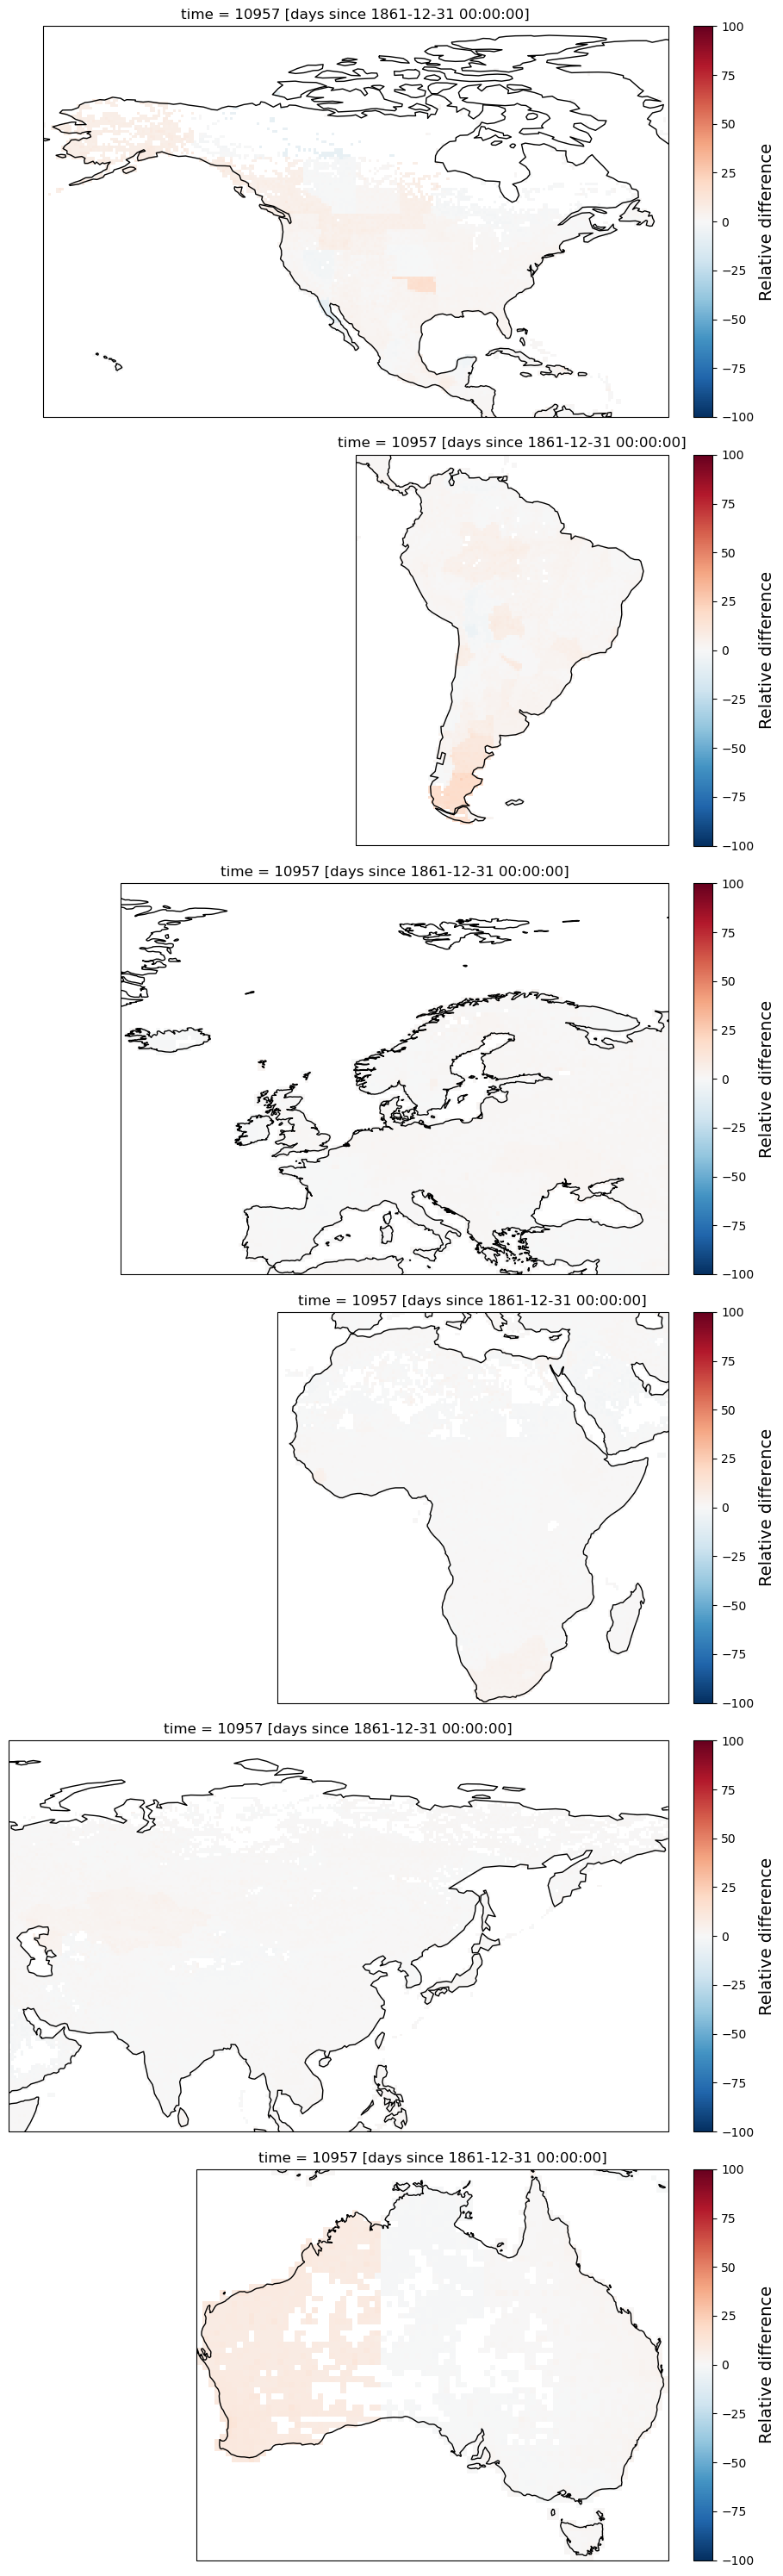

In [158]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np

# Assuming that da is your xarray.DataArray
da = pop_data_1861_2005

# Define the continental extents
extents = {'North America': [-170, -50, 10, 85],
           'South America': [-90, -30, -60, 15],
           'Europe': [-25, 45, 35, 85],
           'Africa': [-20, 55, -35, 40],
           'Asia': [45, 180, 5, 85],
           'Australia': [113, 154, -44, -10]}

# Loop over each year (note: this will skip the first year, as it has no previous year to compare with)
for year in range(15+15, len(pop_data_1861_2005)-1):
    # Calculate the yearly differences and the relative difference
    diff = ((da[year+1] - da[year])/ da[year]) * 100

    fig, axes = plt.subplots(nrows=6, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 30))

    for row, (continent, extent) in enumerate(extents.items()):
        ax = axes[row]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines()

        # Plot the data
        im = diff.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='RdBu_r', vmin=-100, vmax=100)

        # Add a colorbar
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.03)
        cbar.set_label("Relative difference", size=14)

    fig.tight_layout()

    # Save the figure to a pdf file
    plt.savefig(f'../results/test/{year+1861}_difference.pdf')

    plt.close(fig)
    
    print("Year completed: " + str(year+1861))

In [ ]:
len(pop_data_1861_2005)

In [146]:
axes[1,2]

<GeoAxesSubplot: >